# Import required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Excel Data File

In [ ]:
sales_df = pd.read_excel('OnlineRetail.xlsx', dtype = {'CustomerID': str})

Lets check the first five row of the retail data

In [ ]:
sales_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## Explore DataTypes

In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


## Explore Missing values

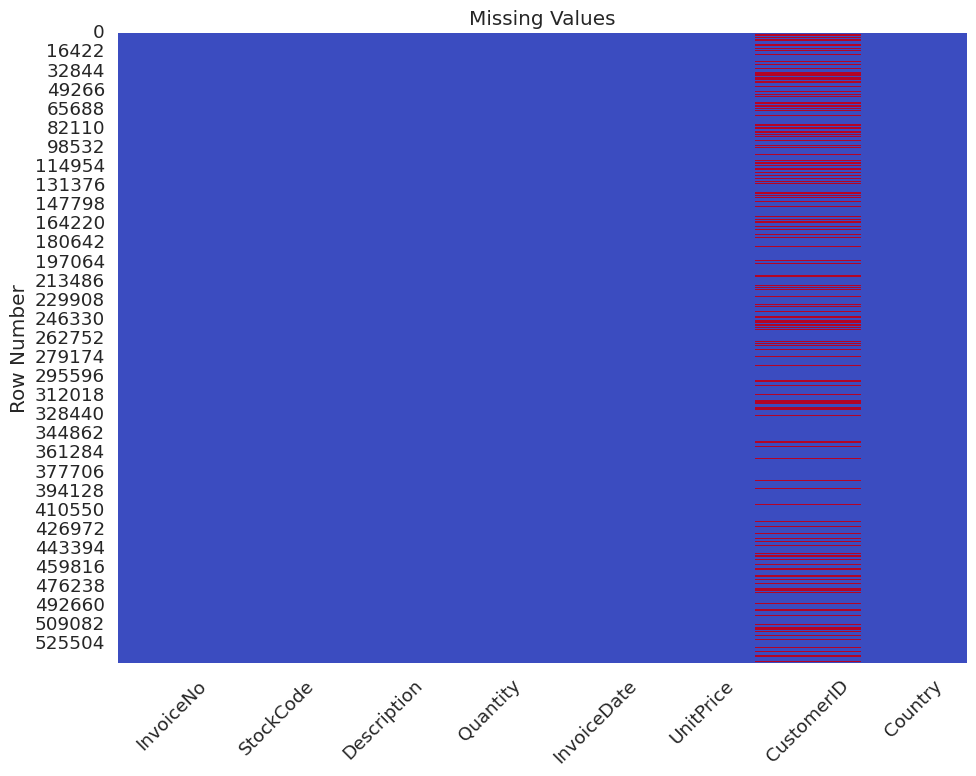

In [ ]:
# which rows contains null values
plt.figure(figsize=(10,8))
sns.heatmap(sales_df.isna(), cmap = 'coolwarm', cbar = False)
plt.title('Missing Values')
plt.xticks(rotation=45)
plt.ylabel('Row Number')
plt.tight_layout()

* Attribute Description  and CustomerID contains missing rows, lets find how may are there below

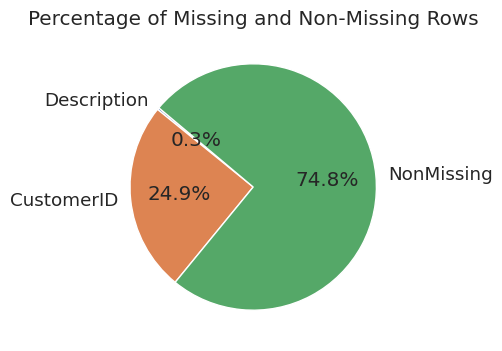

In [ ]:
# Calculate the percentage of missing rows for each column
total_rows = len(sales_df)
percent_missing_rows = (sales_df.isna().sum() / total_rows) * 100

# Filter columns with missing values
null_col_names = percent_missing_rows[percent_missing_rows > 0].index

# Data for the pie chart
missing_values = percent_missing_rows[null_col_names]
non_missing_values = 100-missing_values.sum()
combined = pd.concat([missing_values, pd.Series({'NonMissing': non_missing_values})])
combined

# Create a pie chart
plt.figure(figsize=(6, 4))
plt.pie(combined, labels=combined.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Missing and Non-Missing Rows')
plt.show()

* Almost 25% of the CustomerID's are missing and we cannot impute the values of the column we will simply drop those rows and proceed

In [ ]:
# drop all rows with null
sales_df1 = sales_df.copy()
sales_df1.dropna(inplace = True)

## Explore Statisctis

In [ ]:
# @title Default title text
sales_df1.describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


* Quantity seems to have a negative value
* Max Quantity: 406829
* Min Quantity: -80995

Lets dive into it and explore further how many of those rows are negative below

In [ ]:
# Counting and printing total negative rows
negative_quantity_cnt = sales_df1.loc[sales_df1['Quantity']< 0, 'Quantity'].count()
print(f'Attribute Quantity contains {negative_quantity_cnt} negative rows')

Attribute Quantity contains 8905 negative rows


### Top Returned Invoices

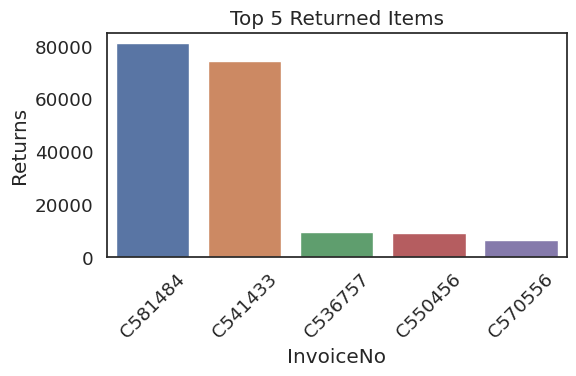

In [ ]:
# group by Invoice number and count number of negative quantity in each group

top_returns = sales_df1[sales_df1['Quantity']<0].groupby('InvoiceNo')['Quantity'].sum().sort_values() * -1
plt.figure(figsize=(6,4))
sns.barplot(x = top_returns.index[0:5], y = top_returns.values[0:5])
plt.xticks(rotation=45)
plt.ylabel('Returns')
plt.title('Top 5 Returned Items')
plt.tight_layout()

* It looks like the All invoice number for negative quantity starts with C but will check if this holds true below
* Max return is by InoviceNo C581484

In [ ]:
# filtering rows if it doesnot start with C
Invoice_group_neg_quantity = sales_df1[sales_df1['Quantity']<0].groupby('InvoiceNo')['InvoiceNo'].count()
Invoice_group_neg_quantity[~Invoice_group_neg_quantity.index.str.contains('C')]

Series([], Name: InvoiceNo, dtype: int64)

* All Invoice number does starts with C
* I assume C means Canceled Transaction or in simple word purchase is returned by the customer

Lets group by Description and see how is this returned invoice described

### Top Returned Categories

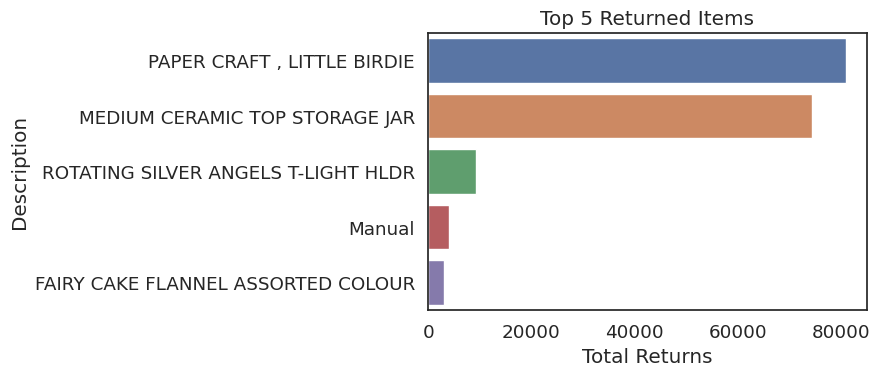

In [ ]:
top_returns = sales_df1[sales_df1['Quantity']<0].groupby('Description')['Quantity'].sum().sort_values() * -1
plt.figure(figsize=(9,4))
sns.barplot(y = top_returns.index[0:5], x = top_returns.values[0:5])
#plt.xticks(rotation=45)
plt.xlabel('Total Returns')
plt.title('Top 5 Returned Items')
plt.tight_layout()

### Top Customer that returned Items

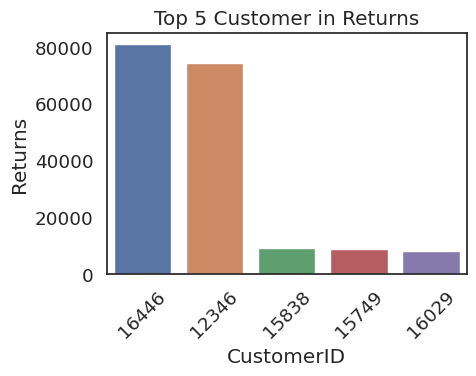

In [ ]:
top_returns = sales_df1[sales_df1['Quantity']<0].groupby('CustomerID')['Quantity'].sum().sort_values() * -1
plt.figure(figsize=(5,4))
sns.barplot(x = top_returns.index[0:5], y = top_returns.values[0:5])
plt.xticks(rotation=45)
plt.ylabel('Returns')
plt.title('Top 5 Customer in Returns')
plt.tight_layout()

Will check if it was one time return or number of returns for top two customer, number of returns

In [ ]:
returned_df = sales_df1[((sales_df1['CustomerID'] == '16446') | (sales_df1['CustomerID'] == '12346') | (sales_df1['CustomerID'] == '15838') |  (sales_df1['CustomerID'] == '15749') | (sales_df1['CustomerID'] == '16029'))
          & (sales_df1['Quantity'] < 0)].sort_values(by = 'CustomerID')
returned_df.head() #displaying only 15 rows below

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
160141,C550456,48185,DOORMAT FAIRY CAKE,-670,2011-04-18 13:08:00,6.75,15749,United Kingdom
160142,C550456,47566B,TEA TIME PARTY BUNTING,-1300,2011-04-18 13:08:00,2.55,15749,United Kingdom
160143,C550456,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1930,2011-04-18 13:08:00,2.55,15749,United Kingdom
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.85,15749,United Kingdom


Top two returns were bought and returned at once
* May be product was of low quality and customer returned it
* May be product was allright but then Customer bought ordered it mistakenly

Lets dig more into it

In [ ]:
sales_df1[(((sales_df1['CustomerID'] == '16446') | (sales_df1['CustomerID'] == '12346')) & (sales_df1['Quantity'] != 1))].sort_values(by = 'CustomerID')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom


Looking at the Invoice date the order time and cancelled time is about 15 to 20 mins apart, Customer did mistakenly ordered and canceled it.

**Lets get rid of all those cancelled rows from the data**

In [ ]:
returned_df = sales_df1[(sales_df1['Quantity']<0)].sort_values(by = 'CustomerID')
returned_df['ReturnDate'] = returned_df['InvoiceDate'].dt.date
returned_df #displaying only 15 rows below

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ReturnDate
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,2011-01-18
106395,C545329,M,Manual,-1,2011-03-01 15:47:00,183.75,12352,Norway,2011-03-01
106397,C545330,M,Manual,-1,2011-03-01 15:49:00,376.50,12352,Norway,2011-03-01
129737,C547388,84050,PINK HEART SHAPE EGG FRYING PAN,-12,2011-03-22 16:07:00,1.65,12352,Norway,2011-03-22
129738,C547388,37448,CERAMIC CAKE DESIGN SPOTTED MUG,-12,2011-03-22 16:07:00,1.49,12352,Norway,2011-03-22
...,...,...,...,...,...,...,...,...,...
488522,C577832,22423,REGENCY CAKESTAND 3 TIER,-1,2011-11-22 10:18:00,12.75,18274,United Kingdom,2011-11-22
481921,C577390,23401,RUSTIC MIRROR WITH LACE HEART,-1,2011-11-18 17:01:00,6.25,18276,United Kingdom,2011-11-18
481908,C577386,23401,RUSTIC MIRROR WITH LACE HEART,-1,2011-11-18 16:54:00,6.25,18276,United Kingdom,2011-11-18
70604,C542086,22423,REGENCY CAKESTAND 3 TIER,-1,2011-01-25 12:34:00,12.75,18277,United Kingdom,2011-01-25


In [ ]:
sales_df1['ReturnDate'] = sales_df1['InvoiceDate'].dt.date
sales_df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ReturnDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01


In [ ]:
#geeting rid of all retuned invoices
filtered_df = sales_df1.iloc[~sales_df1.index.isin(returned_df.index), :]
filtered_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ReturnDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01


In [ ]:
joined_df = filtered_df.merge(returned_df, how = 'inner', on = ['CustomerID','ReturnDate'],suffixes=('_left', '_right'))
joined_df[(joined_df['Quantity_left'] * -1 == joined_df['Quantity_right']) & (joined_df['Description_left'] == joined_df['Description_right'])]

,InvoiceNo_left,StockCode_left,Description_left,Quantity_left,InvoiceDate_left,UnitPrice_left,CustomerID,Country_left,ReturnDate,InvoiceNo_right,StockCode_right,Description_right,Quantity_right,InvoiceDate_right,UnitPrice_right,Country_right
718,537140,20685,DOORMAT RED RETROSPOT,1,2010-12-05 12:53:00,7.95,12748,United Kingdom,2010-12-05,C537143,20685,DOORMAT RED RETROSPOT,-1,2010-12-05 12:58:00,7.95,United Kingdom
956,537144,35953,FOLKART STAR CHRISTMAS DECORATIONS,24,2010-12-05 13:00:00,1.25,15880,United Kingdom,2010-12-05,C537157,35953,FOLKART STAR CHRISTMAS DECORATIONS,-24,2010-12-05 13:09:00,1.25,United Kingdom
1101,537298,21349,IVY HEART WREATH,4,2010-12-06 11:37:00,6.75,13497,United Kingdom,2010-12-06,C537314,21349,IVY HEART WREATH,-4,2010-12-06 11:42:00,6.75,United Kingdom
1117,537377,22865,HAND WARMER OWL DESIGN,10,2010-12-06 13:01:00,2.10,15882,United Kingdom,2010-12-06,C537379,22865,HAND WARMER OWL DESIGN,-10,2010-12-06 13:12:00,2.10,United Kingdom
1246,537391,22371,AIRLINE BAG VINTAGE TOKYO 78,1,2010-12-06 13:53:00,4.25,16550,United Kingdom,2010-12-06,C537383,22371,AIRLINE BAG VINTAGE TOKYO 78,-1,2010-12-06 13:17:00,4.25,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113840,581166,23079,TOADSTOOL BEDSIDE LIGHT,1,2011-12-07 14:43:00,8.95,15525,United Kingdom,2011-12-07,C581178,23079,TOADSTOOL BEDSIDE LIGHT,-1,2011-12-07 15:39:00,8.95,United Kingdom
113848,581166,23079,TOADSTOOL BEDSIDE LIGHT,1,2011-12-07 14:43:00,8.95,15525,United Kingdom,2011-12-07,C581178,23079,TOADSTOOL BEDSIDE LIGHT,-1,2011-12-07 15:39:00,8.95,United Kingdom
113910,581325,16169E,WRAP 50'S CHRISTMAS,100,2011-12-08 11:53:00,0.42,15877,United Kingdom,2011-12-08,C581330,16169E,WRAP 50'S CHRISTMAS,-100,2011-12-08 11:57:00,0.42,United Kingdom
113913,581325,22959,WRAP CHRISTMAS VILLAGE,25,2011-12-08 11:53:00,0.42,15877,United Kingdom,2011-12-08,C581330,22959,WRAP CHRISTMAS VILLAGE,-25,2011-12-08 11:57:00,0.42,United Kingdom


In [ ]:
InvoiceNo_left = joined_df['InvoiceNo_left'].unique()
Invoice_right = returned_df['InvoiceNo'].unique()

In [ ]:
sales_df2 = sales_df1[~sales_df1['InvoiceNo'].isin(returned_df['InvoiceNo'])]
filtered_sales_df = sales_df2[~sales_df2['InvoiceNo'].isin(joined_df['InvoiceNo_left']) ]
retail_df = filtered_sales_df.copy()
retail_df['TotalAmount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ReturnDate,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34


<Axes: xlabel='TotalAmount', ylabel='Count'>

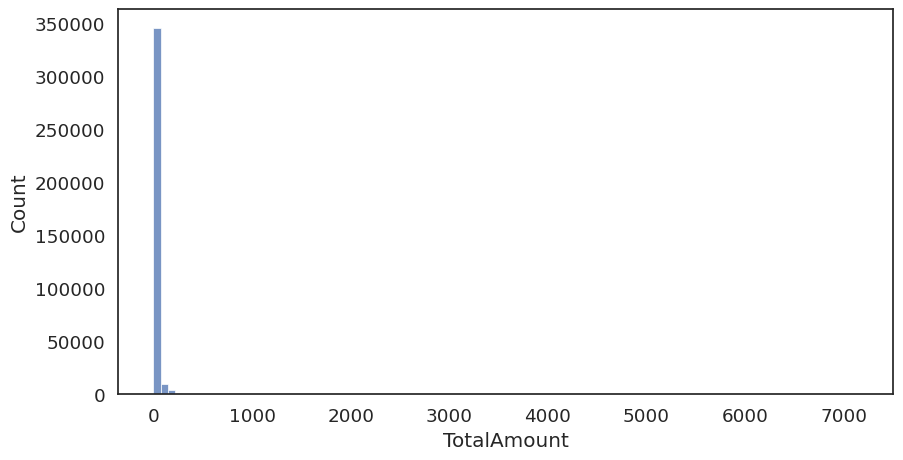

In [ ]:
plt.figure(figsize = (10,5))
sns.histplot(x = retail_df['TotalAmount'], bins = 100)

* Data is higly right skewed, it is common in retail, there will be few customer spending thousands of dollor

### Number of Unique Customers in Each Country

Text(0.5, 1.0, 'Unique Customers by Country')

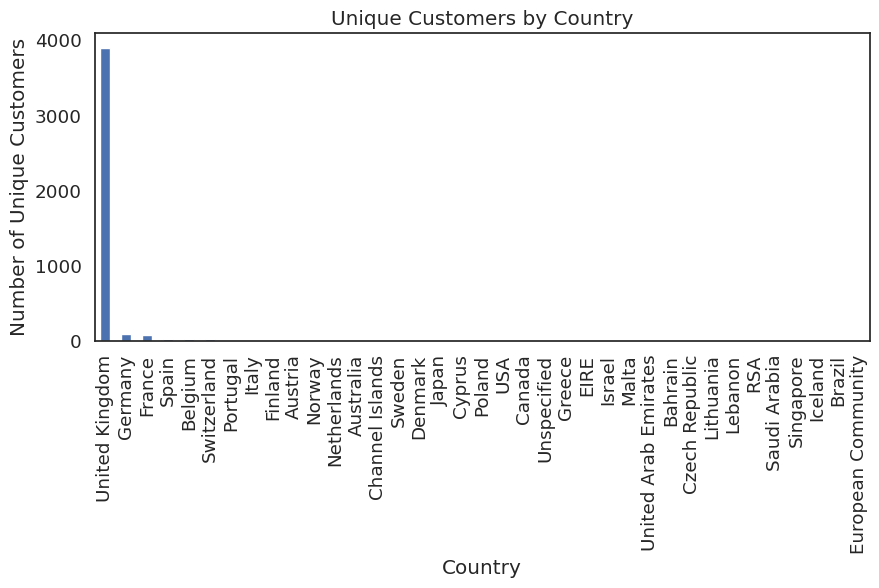

In [ ]:
plt.figure(figsize=(10, 4))
retail_df.groupby('Country')['CustomerID'].nunique().sort_values(ascending = False).plot(kind = 'bar')
plt.xlabel('Country')
plt.ylabel('Number of Unique Customers')
plt.title('Unique Customers by Country')

# Feature Enginnering

## RFM Customer Segmentation

In [ ]:
#Find out the first and last order dates in the data.
retail_df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [ ]:
retail_df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

* Since recency is calculated for a point in time, and the last invoice date is 2011–12–09, we will use 2011–12–10 to calculate recency.

In [ ]:
import datetime as dt
NOW = dt.datetime(2011,12,10)
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])

In [ ]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ReturnDate,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34


### Calculate and Create RFM Table

In [ ]:
rfmTable = retail_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency',
                         'InvoiceNo': 'frequency',
                         'TotalAmount': 'monetary_value'}, inplace=True)

In [ ]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerID,,,
12347,2,182,4310.00
12348,75,31,1797.24
12349,18,73,1757.55
12350,310,17,334.40
12352,36,69,1361.06


## Split the metrics

The easiest way to split metrics into segments is by using quartiles.

This gives us a starting point for the detailed analysis.
4 segments are easy to understand and explain.

In [ ]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

### Create a segmented RFM table

* The lowest recency, highest frequency and monetary amounts are our best customers.

In [ ]:
segmented_rfm = rfmTable


In [ ]:
# Function to calculate quantile scores
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [ ]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12347,2,182,4310.00,1,1,1
12348,75,31,1797.24,3,3,1
12349,18,73,1757.55,1,2,1
12350,310,17,334.40,4,4,3
12352,36,69,1361.06,2,2,2


* RFM segments split the customer base into an imaginary 3D cube which is hard to visualize. However, we can sort it out.
* We will add a new column to combine RFM score to simply it

**Note: Each quartile score ranges from 1 to 4, with 1 being the best (indicating the highest recency, frequency, or monetary value) and 4 being the worst (indicating the lowest recency, frequency, or monetary value)**

In [ ]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head() #map convert the quartile to string and concantenate them together

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12347,2,182,4310.00,1,1,1,111
12348,75,31,1797.24,3,3,1,331
12349,18,73,1757.55,1,2,1,121
12350,310,17,334.40,4,4,3,443
12352,36,69,1361.06,2,2,2,222


**Who are the top 10 of our best customers**

In [ ]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
14646,1,2062,278899.74,1,1,1,111
18102,0,417,256581.14,1,1,1,111
17450,8,318,188855.46,1,1,1,111
14911,1,4517,111939.27,1,1,1,111
14156,9,1323,107637.72,1,1,1,111
16684,4,276,66504.10,1,1,1,111
13694,3,515,58114.22,1,1,1,111
13089,2,1795,58080.43,1,1,1,111
17511,2,593,55112.74,1,1,1,111


**Who are our worst customers**

In [ ]:
segmented_rfm[segmented_rfm['RFMScore']=='444'].sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
16217,235,15,304.25,4,4,4,444
18185,249,17,304.25,4,4,4,444
14248,318,8,302.58,4,4,4,444
18165,177,10,302.46,4,4,4,444
17094,322,14,302.00,4,4,4,444
13479,200,15,300.95,4,4,4,444
17978,365,12,300.92,4,4,4,444
15609,184,16,298.48,4,4,4,444
17678,263,16,298.11,4,4,4,444


* We need to do some things about these customers to make them loyal to our or store, or focus on other because these are lost customer.

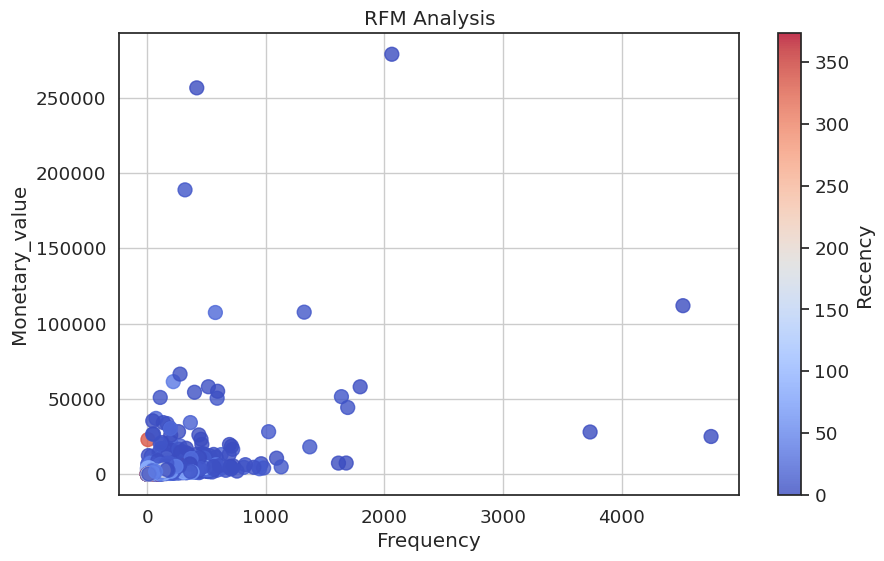

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(segmented_rfm['frequency'], segmented_rfm['monetary_value'], c=segmented_rfm['recency'], cmap='coolwarm', s=100, alpha=0.8)
plt.xlabel('Frequency')
plt.ylabel('Monetary_value')
plt.title('RFM Analysis')
plt.colorbar(label='Recency')
plt.grid(True)
plt.show()

# Cluster Analysis

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

df_Kmeans = rfmTable[['recency','frequency','monetary_value']].copy()

# data needs to be scaled for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_Kmeans)
X_scaled


array([[-9.10268747e-01,  5.76930221e-01,  3.09039087e-01],
       [-1.84022235e-01, -3.12855728e-01, -6.85202994e-03],
       [-7.51091429e-01, -6.53655962e-02, -1.18416503e-02],
       ...,
       [-8.60525835e-01, -4.24815549e-01, -2.10408174e-01],
       [-9.00320164e-01,  3.95929535e+00,  3.05657226e-02],
       [-5.12325453e-01, -8.30434627e-02, -1.81840941e-03]])

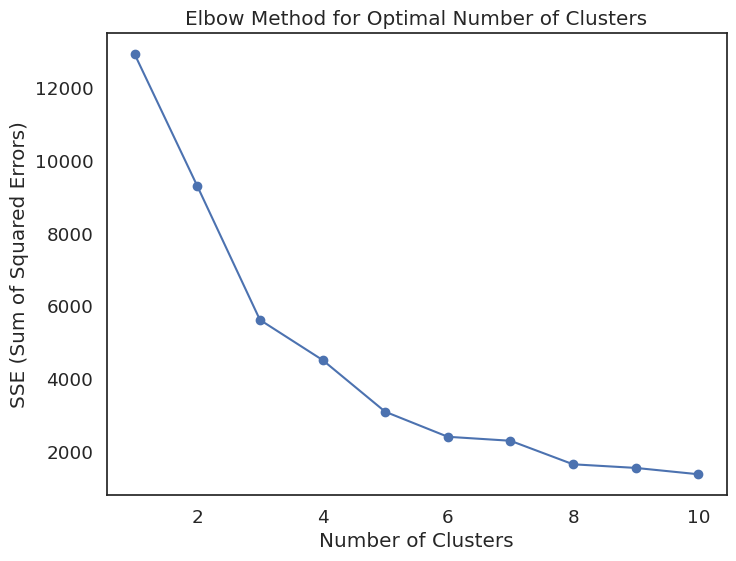

In [ ]:
# Calculate the Elbow curve to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

* It looks like around 5 or 6 the elow slope started decreacing slowly
* Either we can choose 5 cluster or 6 cluster
* lets check this with silhoutte score to find optimal number of cluster

### Use Silhoutte Score to find optimal number of clusters

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Define the range of cluster numbers to try/defining the parameters
X = X_scaled
min_clusters = 2
max_clusters = 10
random_seed = np.random.randint(low=1, high=1001, size=20)  # 20 random seeds

# Initialize an empty list to store the silhouette scores
optimal_n_clusters = []

# Loop through each seed and calculate silhouette scores for different numbers of clusters
for seed in random_seed:
    silhouette_scores = []  # Store silhouette scores for each seed
    for n_clusters in range(min_clusters, max_clusters + 1):
        # Initialize a KMeans object with the current number of clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init='auto')

        # Fit the model and get the cluster labels
        cluster_labels = kmeans.fit_predict(X)

        # Calculate the silhouette score for this clustering
        silhouette = silhouette_score(X, cluster_labels)

        # Add the score to the list of scores
        silhouette_scores.append(silhouette)

    # Find the optimal number of clusters based on the maximum silhouette score for this seed
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + min_clusters
    optimal_n_clusters.append(optimal_clusters)

# Find the maximum occurrence of an element in the list
max_count = max([optimal_n_clusters.count(x) for x in optimal_n_clusters])

# Create an empty list to hold the elements with the maximum occurrence
max_elements = []

# Iterate through the list and add each element with the maximum occurrence to the new list
for x in optimal_n_clusters:
    if optimal_n_clusters.count(x) == max_count and x not in max_elements:
        max_elements.append(x)

# Print the optimal number of clusters
print(f"The optimal number of clusters is {max_elements}")
print(f"The silhouette_scores is {round(max(silhouette_scores), 2)}")


The optimal number of clusters is [5]
The silhouette_scores is 0.6


* It looks like 5 is the optimal cluster for our dataset

In [ ]:
# Determine the optimal number of clusters from the Elbow curve (here, let's assume 5 clusters)
optimal_clusters = 5

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init = 'auto')
kmeans.fit(X_scaled)

# Add cluster labels to the df DataFrame
df_Kmeans.loc[:, 'cluster'] = kmeans.labels_


# Print cluster centers
print("Cluster Centers:")
print(df_Kmeans.groupby('cluster').median())

Cluster Centers:
         recency  frequency  monetary_value
cluster                                    
0          244.0       18.0          309.46
1            9.0      334.5         5319.11
2            1.0     4517.0        28064.85
3            1.0      417.0       256581.14
4           35.0       47.0          773.99


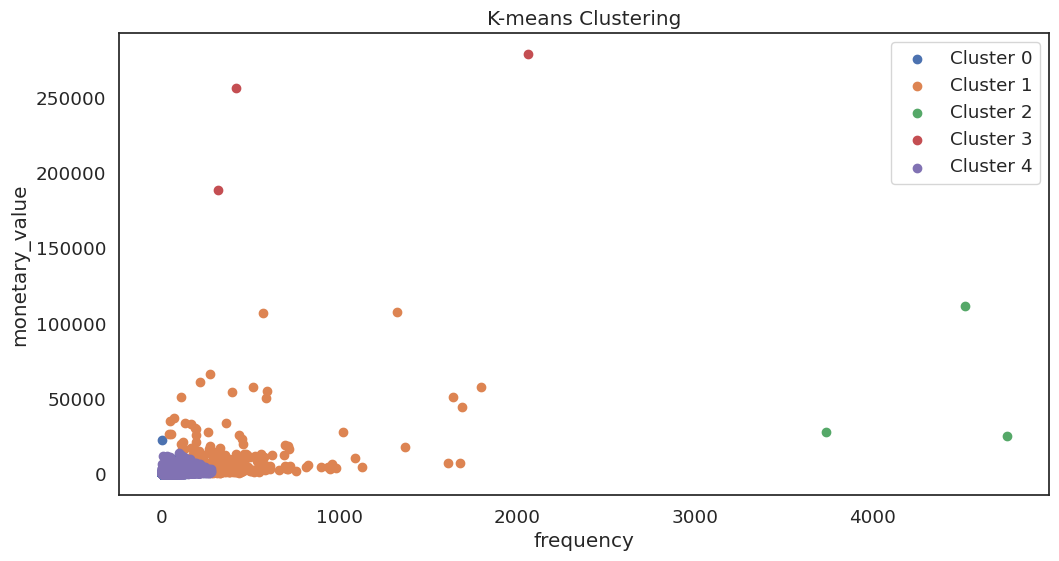

In [ ]:
# Visualize the clusters
plt.figure(figsize=(12, 6))
for i in range(optimal_clusters):
    cluster_data = df_Kmeans[df_Kmeans['cluster'] == i]
    plt.scatter(cluster_data['frequency'], cluster_data['monetary_value'], label=f'Cluster {i}')

plt.xlabel('frequency')
plt.ylabel('monetary_value')
plt.title('K-means Clustering')
plt.legend()
plt.show()

* lets blox plot clusters for each columns

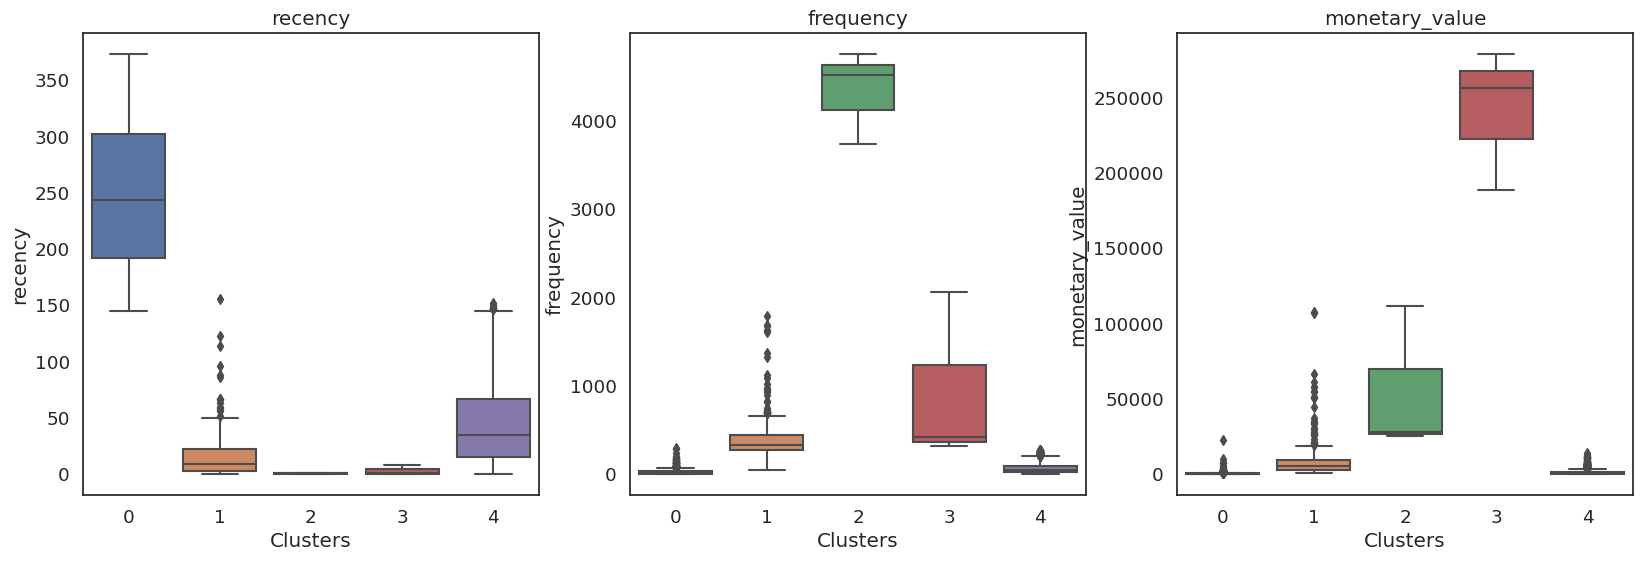

In [ ]:
var = ['recency', 'frequency', 'monetary_value']
# Create subplots with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, v in enumerate(var):
    # Select the ith axis
    sns.boxplot(x="cluster", y=v, data=df_Kmeans, ax=ax[i])
    ax[i].set_title(v)
    ax[i].set_xlabel('Clusters')
    ax[i].set_ylabel(v)

* cluster 3 is our best loyal customer
* Cluster 2 is our second best customer
* cluster 1 and 4 needes to be done something to make them more frequent and spend more money
* cluster 0 is the worst of all, we lost them already

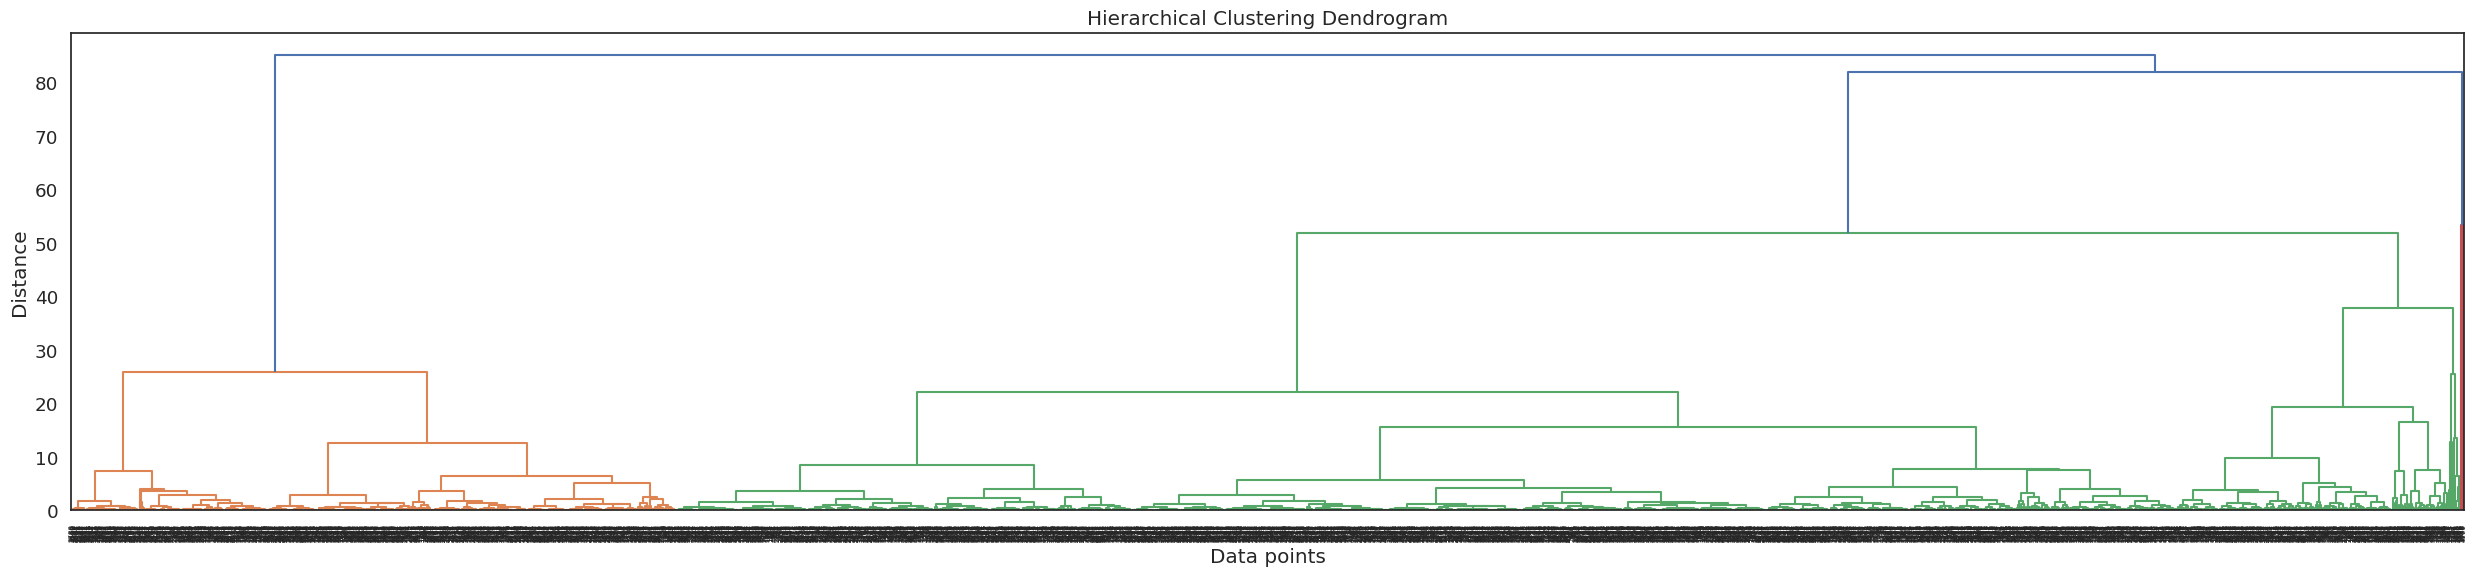

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

df_hirarchical = rfmTable[['recency', 'frequency', 'monetary_value']].copy()

# Visualize the dendrogram
plt.figure(figsize=(25, 6))
linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.tight_layout()

In [ ]:
# Perform hiearchical clustering and cluister numbers
clustering = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward',)
df_hirarchical['cluster'] = clustering.fit_predict(X_scaled)

# Print cluster centers
print("Kmeans Cluster Centers:")
print(df_Kmeans.groupby('cluster').median())
print(f'\n')
print("Hirarchical Cluster Centers:")
print(df_hirarchical.groupby('cluster').median())



Kmeans Cluster Centers:
         recency  frequency  monetary_value
cluster                                    
0          244.0       18.0          309.46
1            9.0      334.5         5319.11
2            1.0     4517.0        28064.85
3            1.0      417.0       256581.14
4           35.0       47.0          773.99


Hirarchical Cluster Centers:
         recency  frequency  monetary_value
cluster                                    
0           11.0      267.0        3805.690
1          242.0       18.5         311.255
2            1.0      417.0      256581.140
3            1.0     4517.0       28064.850
4           36.0       42.0         704.145


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Assuming X_scaled is your scaled feature matrix

# Define the range of cluster numbers to try
min_clusters = 2
max_clusters = 10

# Initialize an empty list to store the silhouette scores
silhouette_scores = []
optimal_n_clusters = []

# Loop through each number of clusters and calculate the silhouette score
for n_clusters in range(min_clusters, max_clusters+1):
    # Initialize an AgglomerativeClustering object with the current number of clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward',)

    # Fit the model and get the cluster labels
    cluster_labels = clustering.fit_predict(X_scaled)

    # Calculate the silhouette score for this clustering
    silhouette = silhouette_score(X_scaled, cluster_labels)

    # Add the score to the list of scores
    silhouette_scores.append(silhouette)

    # Append the current number of clusters to the list of optimal clusters
    optimal_n_clusters.append(n_clusters)

# Find the optimal number of clusters based on the maximum silhouette score
optimal_clusters = optimal_n_clusters[silhouette_scores.index(max(silhouette_scores))]

# Print the optimal number of clusters and corresponding silhouette score
print(f"The optimal number of clusters is {optimal_clusters}")
print(f"The silhouette score is {round(max(silhouette_scores), 2)}")


The optimal number of clusters is 4
The silhouette score is 0.57


Please note Kmeans cluster and Hirarchical clustering produced almost similar results, only the cluster number are diffrent but it means the same thing.

Cluster 3: This cluster has customers with extremely recent and frequent purchases and an exceptionally high monetary value. These customers seem to be highly engaged and valuable.
Cluster 2: While it contains only a few customers, this cluster consists of highly engaged and high-value customers with very recent and frequent purchases.
Cluster 0: Customers in this cluster have made recent and frequent purchases with a high monetary value. They are likely valuable and engaged customers.
Cluster 4: This cluster represents customers with moderate engagement and value. Their recency, frequency, and monetary values are moderate.
Cluster 1: This cluster contains customers with less recent and fewer purchases, resulting in a lower overall value compared to the other clusters.



* Both the clustering algorithms values are realtively close, based on silhouette We will use K-Means clustering for the further analysis




In [ ]:
# Identify churn risk criteria (example: recency greater than 30 days)
churn_risk_criteria = 30

# Create a new column 'Churn_Risk' based on the criteria
df = df_Kmeans.copy()
df['Churn_Risk'] = df['recency'] > churn_risk_criteria

# Identify at-risk customers within each cluster
at_risk_cluster_0 = df[(df['cluster'] == 0) & (df['Churn_Risk'])]
at_risk_cluster_1 = df[(df['cluster'] == 1) & (df['Churn_Risk'])]
at_risk_cluster_2 = df[(df['cluster'] == 2) & (df['Churn_Risk'])]
at_risk_cluster_3 = df[(df['cluster'] == 3) & (df['Churn_Risk'])]
at_risk_cluster_4 = df[(df['cluster'] == 4) & (df['Churn_Risk'])]

# Implement retention strategies for each cluster (customize as needed)
# For example, you can print a message for each cluster
print("Retention Strategies for Cluster 0:")
print("Offer loyalty programs, exclusive access to new products, or personalized recommendations.")



Retention Strategies for Cluster 0:
Offer loyalty programs, exclusive access to new products, or personalized recommendations.


In [ ]:
at_risk_cluster_0.head()

,recency,frequency,monetary_value,cluster,Churn_Risk
CustomerID,,,,,
12350,310,17,334.4,0,True
12353,204,4,89.0,0,True
12354,232,58,1079.4,0,True
12355,214,13,459.4,0,True
12361,287,10,189.9,0,True


In [ ]:
df.head()

,recency,frequency,monetary_value,cluster,Churn_Risk
CustomerID,,,,,
12347,2,182,4310.00,4,False
12348,75,31,1797.24,4,True
12349,18,73,1757.55,4,False
12350,310,17,334.40,0,True
12352,36,69,1361.06,4,True


Text(0.5, 1.0, 'Number of Churn Risk in each K-Means Cluster')

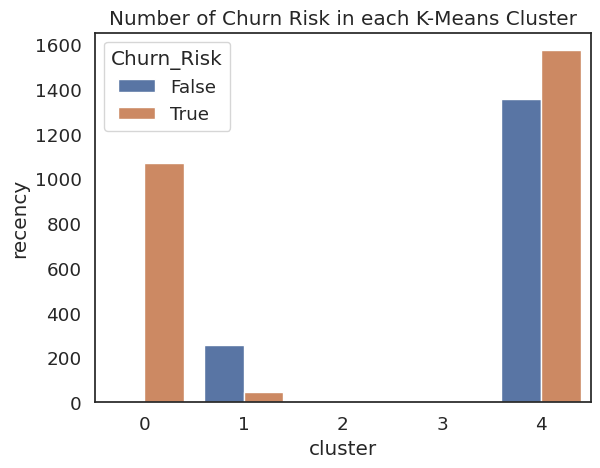

In [ ]:
# number Churn in each cluster
df_plot = df.groupby(['cluster','Churn_Risk']).count()['recency'].reset_index()
sns.barplot(data = df_plot, x = 'cluster', y = 'recency', hue = 'Churn_Risk')
plt.title('Number of Churn Risk in each K-Means Cluster')

# Customer Churn Prediction

## Determining Variable Correlation with Dependent Variable Churn

<Axes: title={'center': 'Correlation with Reposnse variable'}>

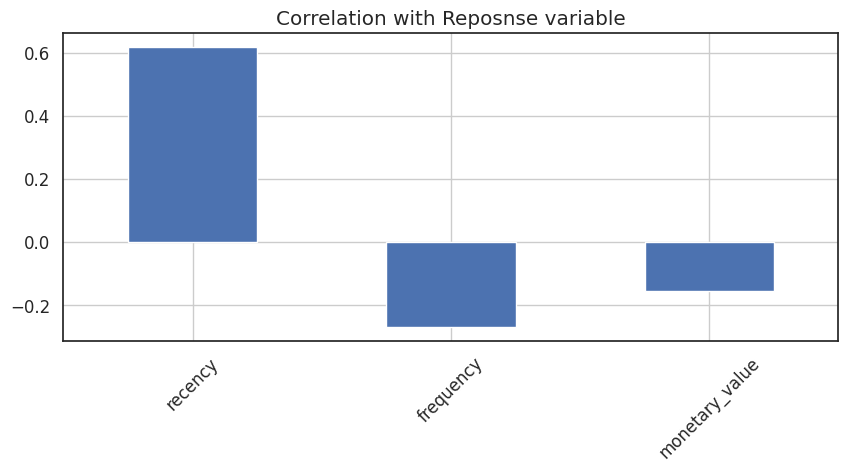

In [ ]:
# Feature Scaling (if needed)
scaler = StandardScaler()
df.iloc[:,0:3].corrwith(df['Churn_Risk']).plot.bar(figsize=(10,4),
                                      title = 'Correlation with Reposnse variable',
                                      fontsize = 12, rot = 45,
                                      grid = True)

* Recency increases Customer is less likely to churn (Positively correlated)
* Frequecy decreases Customer is more likelty to churn (Negatively Correlated)
* Monetary value decreases Customer is more likely to churn (Negatively Correlated)

## Determining Correlation between Independent Variables

<Axes: >

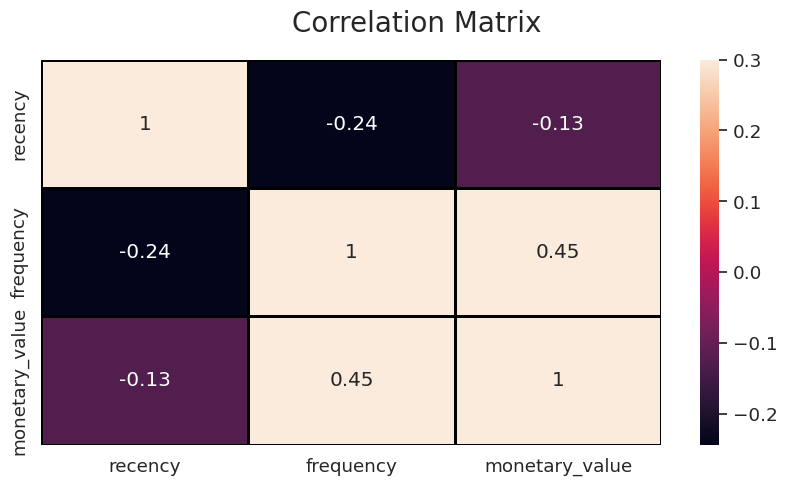

In [ ]:
## Correlation Matrix
sns.set(style="white", font_scale=1.2)

# Compute the correlation matrix
corr = df.iloc[:, 0:3].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))
plt.suptitle("Correlation Matrix", fontsize = 20)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=.3, annot = True, linewidths=.8, linecolor= 'black')

* No significant correlation seen between independent variables

## Determing the the best model using GridSearch CV

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame with labeled churn column
X = df[['recency', 'frequency', 'monetary_value']]
y = df['Churn_Risk']

# Feature Scaling (if needed)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter tuning (example using GridSearch)
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_

# Cross-validated accuracy
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=5)
print("Cross-validated Scores:", cv_scores)
print("Best paramer", best_clf)



Cross-validated Scores: [1. 1. 1. 1. 1.]
Best paramer RandomForestClassifier(random_state=42)


## Using Best Model to predict the customer churn

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       338
        True       1.00      1.00      1.00       525

    accuracy                           1.00       863
   macro avg       1.00      1.00      1.00       863
weighted avg       1.00      1.00      1.00       863



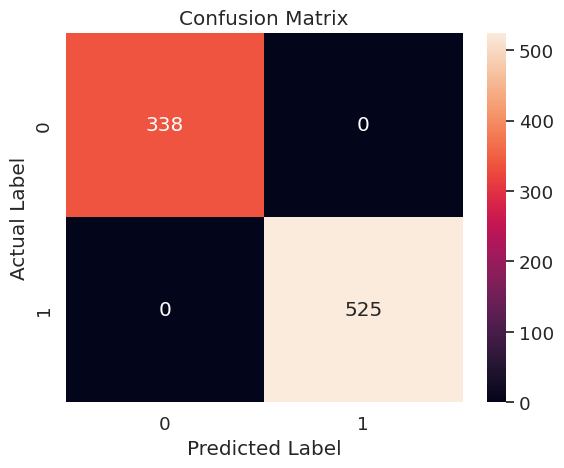

In [ ]:
# Make predictions on the test set
y_pred = best_clf.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


## Determing the most important variable related to churn

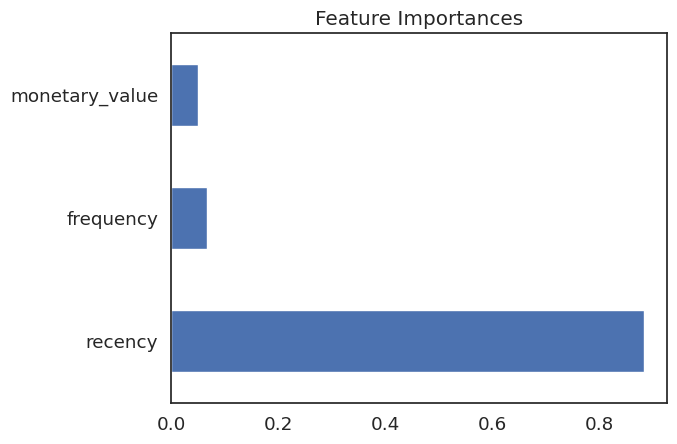

In [ ]:

# Feature Importance Visualization
feature_importances = pd.Series(best_clf.feature_importances_, index=['recency', 'frequency', 'monetary_value'])
feature_importances.nlargest(3).plot(kind='barh')
plt.title('Feature Importances')
plt.show()

* Recency if the important factor in determing Customer churn rate than comes the frequency in the second

In [ ]:
import os
import pickle

directory = "/content/drive/My Drive/YourSubdirectory"
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
with open(os.path.join(directory, 'RetailModel.pkl'), 'wb') as file:
    pickle.dump(best_clf, file)

In [ ]:
with open('RetailModel.pkl', 'wb') as file:
    pickle.dump(best_clf, file)